# **Project 01. Social data textual Classification**
### **A Study on the Social Factors of Low Birth rate from the Rational Choice Theory: Focusing on YouTube Comments**

### **1. Import Dependencies & Load dataset**

In [1]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import pandas as pd
import numpy as np
import random
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

W1201 03:59:32.721000 26384 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
df = pd.read_excel('Senti_multiclassification.xlsx')
df

,document,Despair,Anger,Ridicule,Abandonment,Annihilation,Sentiments
0,닭들이 알낳으면 양계장 주인만 존나 좋아하지않냐? 그게 딱 한국 현실이여,0,0,1,0,0,Ridicule
1,나는 평생 집은 커녕 화장실도 못살꺼같으니 많이 해드신 LH직원분들이랑 국회위원분들...,0,0,0,0,1,Annihilation
2,육아휴직이나 받아주던가 경력단절이나 없던가 월급이나 많던가 교육비나 적던가 내집마련...,0,0,0,0,1,Annihilation
3,나라가 망하는게 문제가 아니라내가 죽게 생겼다,1,0,0,0,0,Despair
4,현재: 제발 애좀 낳으세요 물론 양육비는 처음부터 끝까지 느그가 알아서 하셈 ^^,0,1,0,0,0,Anger
...,...,...,...,...,...,...,...
89596,댓글들 애 안 낳는걸로 시위하나ㅋㅋㅋㅋ꼬라지 봐라,0,0,1,0,0,Ridicule
89597,뭔가 오해하는 사람이 많아보이는데... 해당 뉴스 클립에선 돈이 전부가 아니니까 불...,0,0,0,0,1,Annihilation
89598,나만 근본원인을 알지.ㅋㅋ 공무원들은 몰라. 자기들 연금때문에 모른척하나?,0,0,1,0,0,Ridicule
89599,@집가고싶다 집 값 너무 비싸서 못사서요ㅠㅠ.. 그래서 결혼 안함..ㅋㅋㅋ......,0,1,0,0,0,Anger


### **EDA**

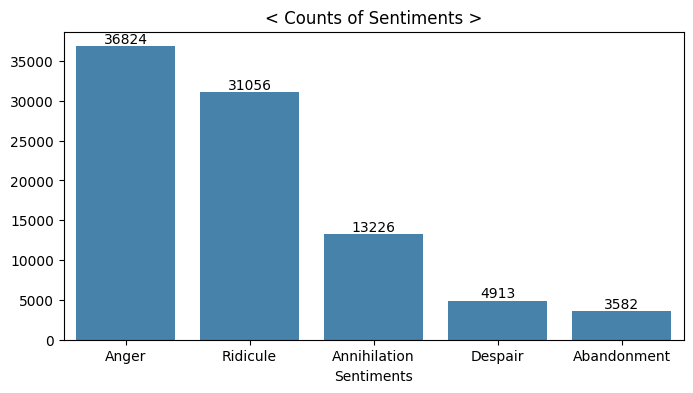

In [3]:
x=df['Sentiments'].value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.9)
plt.title("< Counts of Sentiments >")

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<Axes: title={'center': '< Correlation of Sentiments >'}>

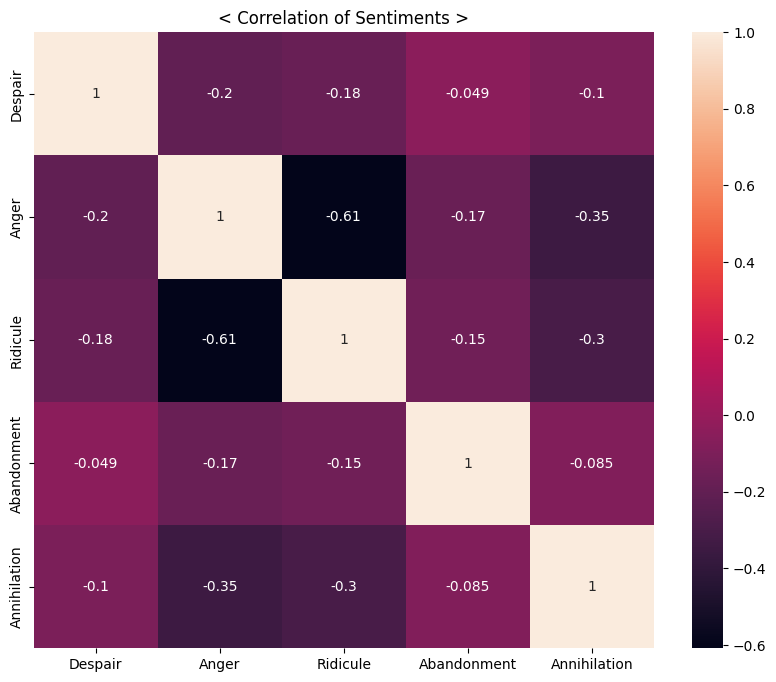

In [4]:
corr=df[['Despair', 'Anger', 'Ridicule', 'Abandonment', 'Annihilation']].corr()
plt.figure(figsize=(10,8))
plt.title("< Correlation of Sentiments >")
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Max length of data : 12
Average length of data : 7.422606890548097


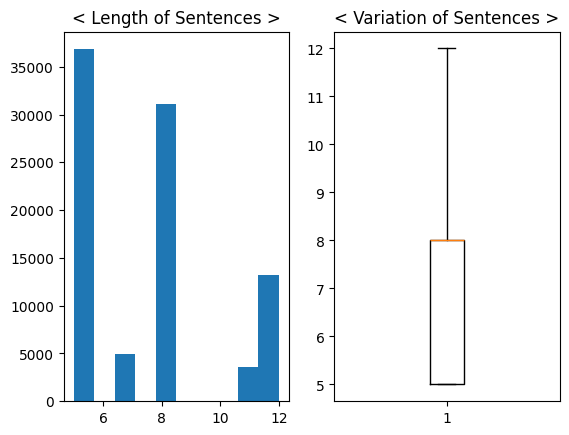

In [5]:
data_length = [len(data) for data in df['Sentiments']]
 
print('Max length of data :', np.max(data_length))
print('Average length of data :', np.mean(data_length))

plt.subplot(1,2,1)
plt.hist(data_length, bins=10)
plt.title("< Length of Sentences >")
plt.subplot(1,2,2)
plt.boxplot(data_length)
plt.title("< Variation of Sentences >")

plt.show()

In [6]:
le = LabelEncoder()
labels = le.fit_transform(df['Sentiments'])

NUM_LABELS = len(le.classes_)
print("Classes:", le.classes_)
print("NUM_LABELS:", NUM_LABELS)

Classes: ['Abandonment' 'Anger' 'Annihilation' 'Despair' 'Ridicule']
NUM_LABELS: 5


In [7]:
df['labels'] = labels
df = df[['document', 'labels']]
df.tail()

,document,labels
89596,댓글들 애 안 낳는걸로 시위하나ㅋㅋㅋㅋ꼬라지 봐라,4
89597,뭔가 오해하는 사람이 많아보이는데... 해당 뉴스 클립에선 돈이 전부가 아니니까 불...,2
89598,나만 근본원인을 알지.ㅋㅋ 공무원들은 몰라. 자기들 연금때문에 모른척하나?,4
89599,@집가고싶다 집 값 너무 비싸서 못사서요ㅠㅠ.. 그래서 결혼 안함..ㅋㅋㅋ......,1
89600,진짜 대한민국이 겁나피해의식에 쩔어있구나 나도 애둘있고 연봉 4000만원 조금넘게 ...,2


In [8]:
df.drop_duplicates(subset = ['document'], inplace=True)
df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['document'].replace('', np.nan, inplace=True)
df = df.dropna(how='any')
print('Size of Data :',len(df))

Size of Data : 87514


C:\Users\Leopolt\AppData\Local\Temp\ipykernel_26384\167992505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset = ['document'], inplace=True)
C:\Users\Leopolt\AppData\Local\Temp\ipykernel_26384\167992505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\Leopolt\AppData\Local\Temp\ipykernel_26384\167992505.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will chang

### **2. Data split & Preprocessing**

In [9]:
train, test = train_test_split(df, random_state=42,test_size=0.3)

print(len(train), 'train examples')
print(len(test), 'test examples')

61259 train examples
26255 test examples


In [10]:
print(train['labels'].value_counts())
print(test['labels'].value_counts())

labels
1    25493
4    20954
2     8985
3     3356
0     2471
Name: count, dtype: int64
labels
1    10931
4     9008
2     3769
3     1459
0     1088
Name: count, dtype: int64


In [11]:
# Preprocessing

document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train['document']]
document_bert[:5]

# Tokenizing

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

# Padding

MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

print('input_ids의 길이 : ',len(input_ids))

['[CLS]', '[UNK]', '대', '##놓', '##고', '비', '##혼', '##주의', '주', '##장하는', '페', '##미', '##니', '##즘', '지', '##원', '##정', '##책', '펴', '##놓', '##고', '왜', '안', '##낳', '##냐', '[UNK]', '[UNK]', '[SEP]']
input_ids의 길이 :  61259


In [12]:
# Attention mask
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


#### **Train - validation split**

In [13]:
# train - validation split

train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids,  train['labels'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.1)

In [14]:
# pytorch tensor

train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels      = torch.tensor(train_labels,      dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)


# BATCH_SIZE
# Fit to GPU's VRAM

BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

print('Size of train_data : ',len(train_data))
print('Size of validation_data : ',len(validation_data))
print('Size of train_dataloader : ',len(train_dataloader))
print('Size of validation_dataloader : ',len(validation_dataloader))

Size of train_data :  55133
Size of validation_data :  6126
Size of train_dataloader :  1723
Size of validation_dataloader :  192


#### **Test data**

In [15]:
# Test data preprocessing

sentences = test['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test['labels'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
#test_labels = torch.tensor(labels)
test_labels       = torch.tensor(labels,            dtype=torch.long)



test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [16]:
device = torch.device("cuda")
device

device(type='cuda')

### **3. Build Model**

In [28]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [29]:
# learning Scheduling

# optimizer
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=2e-5, eps=1e-6)
#optimizer = AdamW(model.parameters(), lr = 2e-5,  eps = 1e-8 )

# epochs
epochs = 10

# training steps
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [30]:
# accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# time
def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
time0 = time.time()
print(time.strftime('%c', time.localtime(time.time())))

# Random seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Initialize gradient
model.zero_grad()


for epoch_i in range(0, epochs):

    # Training data

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_loss = 0

    model.train()

    
    
    for step, batch in enumerate(train_dataloader):
        
        if step % 500 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')
            
        b_input_ids  = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels     = batch[2].to(device)
        
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
    
    
        loss = outputs[0]


        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Validation data

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits_cpu = logits.detach().cpu().numpy()
        pred_flat_M = np.argmax(logits_cpu, axis=1).flatten()
        
        logits = logits_cpu
        label_ids = b_labels.detach().cpu().numpy()


        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


print("")
print("Training complete!")

print("Test took: {:}".format(format_time(time.time() - time0)))

Sun Nov 30 22:29:59 2025

======== Epoch 1 / 10 ========
Training...
  Batch   500 of 1,764.    Elapsed: 0:02:34.
  Batch 1,000 of 1,764.    Elapsed: 0:05:09.
  Batch 1,500 of 1,764.    Elapsed: 0:07:45.

  Average training loss: 0.71
  Training epcoh took: 0:09:07

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:19

======== Epoch 2 / 10 ========
Training...
  Batch   500 of 1,764.    Elapsed: 0:02:36.
  Batch 1,000 of 1,764.    Elapsed: 0:05:12.
  Batch 1,500 of 1,764.    Elapsed: 0:07:48.

  Average training loss: 0.42
  Training epcoh took: 0:09:11

Running Validation...
  Accuracy: 0.87
  Validation took: 0:00:19

======== Epoch 3 / 10 ========
Training...
  Batch   500 of 1,764.    Elapsed: 0:02:36.
  Batch 1,000 of 1,764.    Elapsed: 0:05:11.
  Batch 1,500 of 1,764.    Elapsed: 0:07:47.

  Average training loss: 0.32
  Training epcoh took: 0:09:09

Running Validation...
  Accuracy: 0.88
  Validation took: 0:00:19

======== Epoch 4 / 10 ========
Training...
  Batch

### **4. Metrics (Confusion Matrix)**

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

time1 = time.time()
print(time.strftime('%c', time.localtime(time.time())))

# Test metrics
print(time.strftime('%c', time.localtime(time.time())))
pred_collection = np.array([])
label_collection = np.array([])

t0 = time.time()

model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):

    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)


    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat_M = np.argmax(logits, axis=1).flatten()
    labels_flat_M = label_ids.flatten()

    pred_collection = np.concatenate((pred_collection, pred_flat_M))
    label_collection = np.concatenate((label_collection, labels_flat_M))


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1


print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print("pred_collection : ",len(pred_collection))
print("label_collection : ",len(label_collection))
print(confusion_matrix(pred_collection, label_collection))
print(classification_report(pred_collection, label_collection))

print("Time took: {:}".format(format_time(time.time() - time1)))

Mon Dec  1 00:04:53 2025
Mon Dec  1 00:04:53 2025
  Batch   100  of    841.    Elapsed: 0:00:10.
  Batch   200  of    841.    Elapsed: 0:00:19.
  Batch   300  of    841.    Elapsed: 0:00:29.
  Batch   400  of    841.    Elapsed: 0:00:39.
  Batch   500  of    841.    Elapsed: 0:00:48.
  Batch   600  of    841.    Elapsed: 0:00:58.
  Batch   700  of    841.    Elapsed: 0:01:08.
  Batch   800  of    841.    Elapsed: 0:01:17.

Accuracy: 0.88
Test took: 0:01:21
pred_collection :  26881
label_collection :  26881
[[9978  118   69  798  272]
 [ 106 1265    8   57   71]
 [  45    3  707  172    5]
 [ 593   62  315 8331   56]
 [ 221   60    8   61 3500]]
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     11235
         1.0       0.84      0.84      0.84      1507
         2.0       0.64      0.76      0.69       932
         3.0       0.88      0.89      0.89      9357
         4.0       0.90      0.91      0.90      3850

    accuracy         

### **5. ROC Curve**

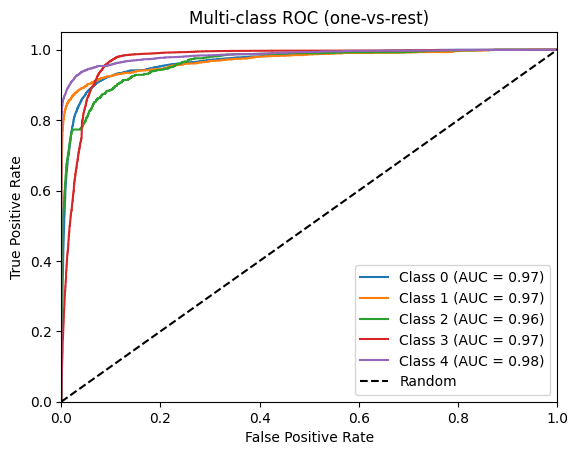

In [ ]:
# Multi-class ROC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

num_classes = 5

model.eval()

all_labels = []
all_logits = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids  = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels     = batch[2].to(device)

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

        logits = outputs[0]

        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(b_labels.detach().cpu().numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize labels for one-vs-rest ROC
y_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# Probabilities
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

# Plot one ROC per class
plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC (one-vs-rest)")
plt.legend(loc="lower right")
plt.show()